In [13]:
!git clone https://github.com/Nadim0403/Data_DL.git

fatal: destination path 'Data_DL' already exists and is not an empty directory.


In [14]:
%matplotlib inline


Tools for ploting

In [15]:
import torch 
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

And load images

In [16]:
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path

dog1_int = read_image('/home/robbie/Downloads/imresizer-1715772421578.jpg')
dog2_int = read_image('resizedCamOutput.jpg')
image_list = [dog1_int, dog2_int]

Now, using a trained CNN model (here we are using [torchvision.models.detection.fasterrcnn_resnet50_fpn](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html)) to predict the bounding boxes.



In [17]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights


weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

inputs = [transforms(d) for d in image_list] # why do we need to transform the images? What is happening during the transformation?

model = fasterrcnn_resnet50_fpn(weights=weights, progress=False) # why do we need to load the weights?
model = model.eval() # what does this do?


outputs = model(inputs)


# What is the shape of the inputs tensors?
# print(inputs[0].shape)

# What is the range of the inputs (max/min values)?
# print(inputs[0].min(), inputs[0].max())

# What are the outputs predictions and how are they packed?
# print(outputs)


Let's plot the boxes detected by our model. We will only plot the boxes with a
score greater than a given threshold.



Box: tensor([[259.8828, 261.6399, 415.6495, 379.9384],
        [139.1352,  18.1115, 521.2524, 256.7856],
        [ 70.9611,  44.3732, 170.4435, 212.3060],
        [ 67.0015, 182.6435, 153.4416, 210.6234]], grad_fn=<IndexBackward0>), Label: tensor([18,  9,  9,  9])
Category Names: ['sofa', 'chair', 'chair', 'chair']


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layer 1, 2, and 3.
Version 0.3.2-1 (2012/03/25). Written and copyrights by Joe Drew,
now maintained by Nanakos Chrysostomos and others.
Uses code from various people. See 'README' for more!
THIS SOFTWARE COMES WITH ABSOLUTELY NO WARRANTY! USE AT YOUR OWN RISK!
tcgetattr(): Inappropriate ioctl for device

Playing MPEG stream from output.mp3 ...
MPEG 2.0 layer III, 32 kbit/s, 24000 Hz mono
                                                                            
[0:03] Decoding of output.mp3 finished.


Box: tensor([[ 10.6176,  56.1249, 600.0000, 594.7743]], grad_fn=<IndexBackward0>), Label: tensor([1])
Category Names: ['aeroplane']


High Performance MPEG 1.0/2.0/2.5 Audio Player for Layer 1, 2, and 3.
Version 0.3.2-1 (2012/03/25). Written and copyrights by Joe Drew,
now maintained by Nanakos Chrysostomos and others.
Uses code from various people. See 'README' for more!
THIS SOFTWARE COMES WITH ABSOLUTELY NO WARRANTY! USE AT YOUR OWN RISK!
tcgetattr(): Inappropriate ioctl for device

Playing MPEG stream from output.mp3 ...
MPEG 2.0 layer III, 32 kbit/s, 24000 Hz mono


['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


                                                                            
[0:02] Decoding of output.mp3 finished.


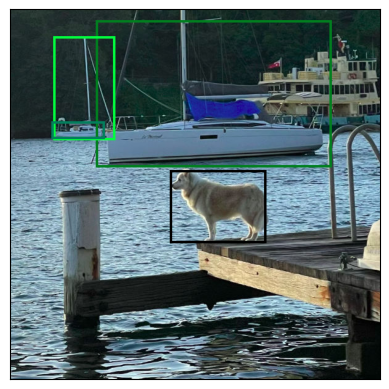

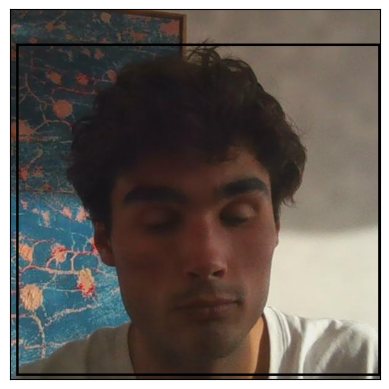

In [25]:
from torchvision.utils import draw_bounding_boxes
from photo import textReformater,textToSpeech

score_threshold = 0.9

# Define the labels you want to filter out
labels_to_filter = [11]

for count, image in enumerate(image_list):
    # Filter out boxes and labels based on score_threshold and labels_to_filter
    filtered_boxes = outputs[count]['boxes'][(outputs[count]['scores'] > score_threshold) & 
                                             torch.logical_not(torch.tensor([label in labels_to_filter for label in outputs[count]['labels']]))]
    filtered_labels = outputs[count]['labels'][(outputs[count]['scores'] > score_threshold) & 
                                                torch.logical_not(torch.tensor([label in labels_to_filter for label in outputs[count]['labels']]))]
    
    # Show the image with filtered bounding boxes

    show(draw_bounding_boxes(image, filtered_boxes, width=4))
    print(f"Box: {filtered_boxes}, Label: {filtered_labels}")
    
    #Get the category names for each filtered label
    category_names = [weights.meta["categories"][label] for label in filtered_labels]
    print(f"Category Names: {category_names}") 
    
    textToSpeech(textReformater(category_names))


#For printint all the catagories available
category_name = weights.meta["categories"][:]
print(f"{category_name}")

### Semantic segmentation models

We will see how to use it with torchvision's FCN Resnet-50, loaded with [fcn_resnet50](https://pytorch.org/vision/main/models/generated/torchvision.models.segmentation.fcn_resnet50.html). Let's start by looking at the output of the model.

In [19]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

weights = FCN_ResNet50_Weights.DEFAULT
transforms = weights.transforms(resize_size=None)

model = fcn_resnet50(weights=weights, progress=False)
model = model.eval()

batch_input = torch.stack([transforms(d) for d in image_list])
output = model(batch_input)['out']
print(f"output shape: {output.shape}, with a min of {output.min().item()} and a max of {output.max().item()}")

output shape: torch.Size([2, 21, 600, 600]), with a min of -5.251246929168701 and a max of 15.53212833404541


As we can see above, the output of the segmentation model is a tensor of shape
``(batch_size, num_classes, H, W)``. Each value is a non-normalized score, and
we can normalize them into ``[0, 1]`` by using a softmax. After the softmax,
we can interpret each value as a probability indicating how likely a given
pixel is to belong to a given class.

Let's plot the masks that have been detected for the dog class and for the
person class:

['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


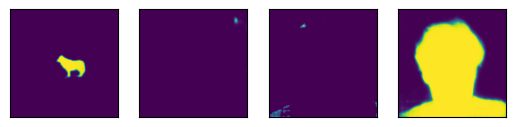

In [20]:
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])} #this is filtering a bunch of catagories need to change 

normalized_masks = torch.nn.functional.softmax(output, dim=1)

masks = [
    normalized_masks[img_idx, sem_class_to_idx[cls]]
    for img_idx in range(len(image_list))
    for cls in ('dog', 'person') #select catagories 
]

print(weights.meta["categories"]) # what are the categories?
show(masks)

The [draw_segmentation_masks](https://pytorch.org/vision/main/generated/torchvision.utils.draw_segmentation_masks.html) function can be used to plots those masks on top of the original image. This function expects the masks to be boolean masks, but our masks above contain probabilities in ``[0, 1]``. To get boolean masks, the outputs have to be thresholded

shape = torch.Size([2, 600, 600]), dtype = torch.bool


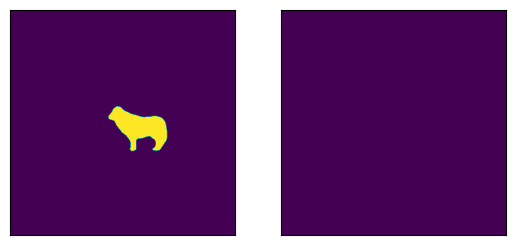

In [21]:
class_dim = 1
boolean_dog_masks = (normalized_masks.argmax(class_dim) == sem_class_to_idx['dog'])
print(f"shape = {boolean_dog_masks.shape}, dtype = {boolean_dog_masks.dtype}")
show([m.float() for m in boolean_dog_masks])

``boolean_dog_masks``  create a mask for which pixels 'dog' is the most likely class prediction.

Now that we have boolean masks, we can use them with [torchvision.utils.draw_segmentation_masks](https://pytorch.org/vision/main/generated/torchvision.utils.draw_segmentation_masks.html) to plot them on top of the original images:

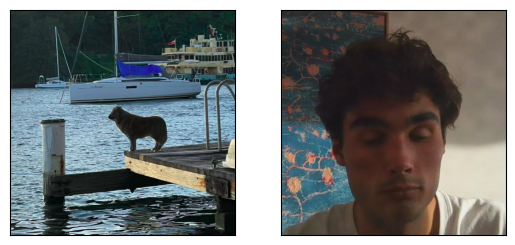

In [22]:
from torchvision.utils import draw_segmentation_masks

dogs_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=0.7)
    for img, mask in zip(image_list, boolean_dog_masks)
]
show(dogs_with_masks)

We can plot more than one mask per image! Remember that the model returned as
many masks as there are classes. Let's ask the same query as above, but this
time for *all* classes, not just the dog class: "For each pixel and each class
C, is class C the most likely class?"

This one is a bit more involved, so we'll first show how to do it with a
single image, and then we'll generalize to the batch



dog1_masks shape = torch.Size([21, 600, 600]), dtype = torch.float32
dog1_all_classes_masks = torch.Size([21, 600, 600]), dtype = torch.bool
torch.Size([21, 600, 600])


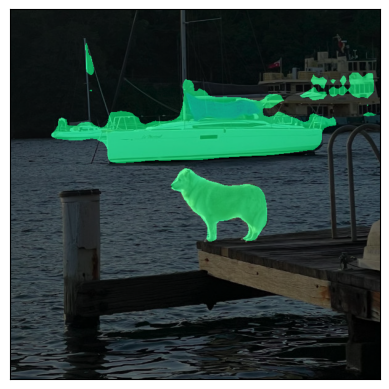

In [23]:
num_classes = normalized_masks.shape[1]
dog1_masks = normalized_masks[0]
class_dim = 0
dog1_all_classes_masks = dog1_masks.argmax(class_dim) == torch.arange(num_classes)[:, None, None]

print(f"dog1_masks shape = {dog1_masks.shape}, dtype = {dog1_masks.dtype}")
print(f"dog1_all_classes_masks = {dog1_all_classes_masks.shape}, dtype = {dog1_all_classes_masks.dtype}")

dog_with_all_masks = draw_segmentation_masks(dog1_int, masks=dog1_all_classes_masks, alpha=.6)
show(dog_with_all_masks)

print(dog1_all_classes_masks.shape)

### Semantic segmentation loss function

In [24]:
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}

normalized_masks = torch.nn.functional.softmax(output, dim=1)

# What loss function can be used for semantic segmentation?
from torch import nn
loss_fn = nn.CrossEntropyLoss()

background = torch.zeros_like(manual_annotation_dog[1])
ground_truth = torch.zeros_like(output)
ground_truth[0][0] = ~((manual_annotation_dog[1]>125) + (manual_annotation_human[1]>125)) # background (note the ~ for negation)
ground_truth[0][12] = (manual_annotation_dog[1]>125) # dog
ground_truth[0][15] = (manual_annotation_human[1]>125) # person

show([ground_truth[0][0].float(), normalized_masks[0][0]])
show([ground_truth[0][12].float(), normalized_masks[0][12]])
show([ground_truth[0][15].float(), normalized_masks[0][15]])

# Compute the loss
loss = loss_fn(normalized_masks[0], ground_truth[0].float())
print(loss)

# Run the backpropagation
#loss.backward()


NameError: name 'manual_annotation_dog' is not defined

## Keypoints extractions
The [torchvision.utils.draw_keypoints](https://pytorch.org/vision/main/generated/torchvision.utils.draw_keypoints.html) function can be used to
draw keypoints on images. We will see how to use it with
torchvision's KeypointRCNN loaded with [torchvision.models.detection.keypointrcnn_resnet50_fpn](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.keypointrcnn_resnet50_fpn.html).
We will first have a look at output of the model.




In [ ]:
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights
from torchvision.io import read_image

person_int = read_image("Data_DL/data/humans/man_4.jpg")

weights = KeypointRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

person_float = transforms(person_int)

model = keypointrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()
model = model.to('cuda:0')

outputs = model([person_float.to('cuda:0')])
print(outputs)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
outputs = model([person_float.to('cuda:0')])

As we see the output contains a list of dictionaries.
The output list is of length batch_size.
We currently have just a single image so length of list is 1.
Each entry in the list corresponds to an input image,
and it is a dict with keys `boxes`, `labels`, `scores`, `keypoints` and `keypoint_scores`.
Each value associated to those keys has `num_instances` elements in it.
In our case above there are multiple instances detected in the image.



In [ ]:
kpts = outputs[0]['keypoints']
scores = outputs[0]['scores']

print(kpts)
print(scores)

tensor([[[266.0052,  75.9062,   1.0000],
         [273.7254,  66.2385,   1.0000],
         [260.2151,  70.1056,   1.0000],
         [295.5992,  63.6604,   1.0000],
         [255.0684,  72.0391,   1.0000],
         [323.9064, 119.0887,   1.0000],
         [254.4250, 117.7997,   1.0000],
         [347.0668, 190.6299,   1.0000],
         [229.9779, 182.2512,   1.0000],
         [347.7101, 254.4368,   1.0000],
         [244.7749, 137.1351,   1.0000],
         [304.6060, 253.7923,   1.0000],
         [255.7117, 253.1478,   1.0000],
         [289.8091, 340.8018,   1.0000],
         [270.5087, 351.7586,   1.0000],
         [311.0394, 441.3462,   1.0000],
         [289.1657, 444.5688,   1.0000]],

        [[418.1938,  61.7184,   1.0000],
         [427.2048,  52.6903,   1.0000],
         [415.6192,  53.3351,   1.0000],
         [454.2377,  61.0735,   1.0000],
         [413.6883,  61.0735,   1.0000],
         [485.1324, 112.0180,   1.0000],
         [411.1138, 110.7282,   1.0000],
         [488.

The KeypointRCNN model detects there are two instances in the image.
We could now set a threshold confidence and plot instances which we are confident enough.
Let us set a threshold of 0.75 and filter out the keypoints corresponding to the person.

In [ ]:
detect_threshold = 0.75
idx = torch.where(scores > detect_threshold)
keypoints = kpts[idx]

print(keypoints)

tensor([[[266.0052,  75.9062,   1.0000],
         [273.7254,  66.2385,   1.0000],
         [260.2151,  70.1056,   1.0000],
         [295.5992,  63.6604,   1.0000],
         [255.0684,  72.0391,   1.0000],
         [323.9064, 119.0887,   1.0000],
         [254.4250, 117.7997,   1.0000],
         [347.0668, 190.6299,   1.0000],
         [229.9779, 182.2512,   1.0000],
         [347.7101, 254.4368,   1.0000],
         [244.7749, 137.1351,   1.0000],
         [304.6060, 253.7923,   1.0000],
         [255.7117, 253.1478,   1.0000],
         [289.8091, 340.8018,   1.0000],
         [270.5087, 351.7586,   1.0000],
         [311.0394, 441.3462,   1.0000],
         [289.1657, 444.5688,   1.0000]],

        [[418.1938,  61.7184,   1.0000],
         [427.2048,  52.6903,   1.0000],
         [415.6192,  53.3351,   1.0000],
         [454.2377,  61.0735,   1.0000],
         [413.6883,  61.0735,   1.0000],
         [485.1324, 112.0180,   1.0000],
         [411.1138, 110.7282,   1.0000],
         [488.

Great, now we have the keypoints corresponding to the person.
Each keypoint is represented by x, y coordinates and the visibility.
We can now use the [draw_keypoints](https://pytorch.org/vision/main/generated/torchvision.utils.draw_keypoints.html) function to draw keypoints.


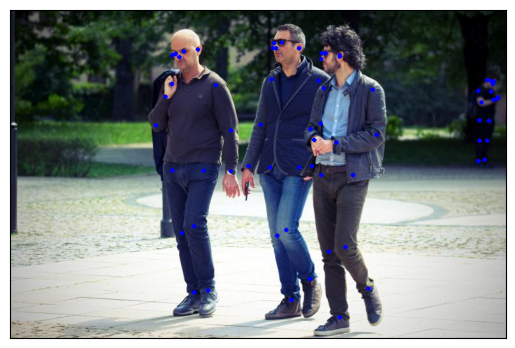

In [ ]:
from torchvision.utils import draw_keypoints

res = draw_keypoints(person_int, keypoints, colors="blue", radius=3)
show(res)

As we see the keypoints appear as colored circles over the image.
The coco keypoints for a person are ordered and represent the following list.\



In [ ]:
coco_keypoints = [
    "nose", "left_eye", "right_eye", "left_ear", "right_ear",
    "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
    "left_wrist", "right_wrist", "left_hip", "right_hip",
    "left_knee", "right_knee", "left_ankle", "right_ankle",
]

What if we are interested in joining the keypoints?
This is especially useful in creating pose detection or action recognition.
We can join the keypoints easily using the `connectivity` parameter.
A close observation would reveal that we would need to join the points in below
order to construct human skeleton.

nose -> left_eye -> left_ear.                              (0, 1), (1, 3)

nose -> right_eye -> right_ear.                            (0, 2), (2, 4)

nose -> left_shoulder -> left_elbow -> left_wrist.         (0, 5), (5, 7), (7, 9)

nose -> right_shoulder -> right_elbow -> right_wrist.      (0, 6), (6, 8), (8, 10)

left_shoulder -> left_hip -> left_knee -> left_ankle.      (5, 11), (11, 13), (13, 15)

right_shoulder -> right_hip -> right_knee -> right_ankle.  (6, 12), (12, 14), (14, 16)

We will create a list containing these keypoint ids to be connected.



In [ ]:
connect_skeleton = [
    (0, 1), (0, 2), (1, 3), (2, 4), (0, 5), (0, 6), (5, 7), (6, 8),
    (7, 9), (8, 10), (5, 11), (6, 12), (11, 13), (12, 14), (13, 15), (14, 16)
]

We pass the above list to the connectivity parameter to connect the keypoints.




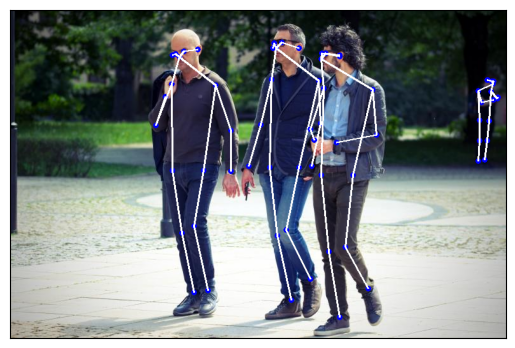

In [ ]:
res = draw_keypoints(person_int, keypoints, connectivity=connect_skeleton, colors="blue", radius=4, width=3)
show(res)